In [11]:
# Imports
import utils.data_exploration as de

import numpy as np
import pandas as pd

# import numexpr as ne
import matplotlib.pyplot as plt
from torchmetrics.functional.classification import binary_stat_scores

In [29]:
# Load Dataframe and confusion matrix
def load_df(i):
    df = pd.read_parquet(f"parquet_data/paper_jan/R{i}_df.parquet")
    CM_df = pd.read_parquet(f"parquet_data/paper_jan/R{i}_CM_df.parquet")
    CM = np.load(f"parquet_data/paper_jan/R{i}_CM.npy", allow_pickle=False)

    return df, CM_df, CM


df, CM_df, CM = load_df(1)
conf_matrix_total = np.sum(CM, axis=0)
metrics = de.conf_matrix_metrics(conf_matrix_total)

In [30]:
false_positive = df[df["Result"] == "FP"]
false_negative = df[df["Result"] == "FN"]

de.false_events_plots(false_positive, "False Positive")
de.false_events_plots(false_negative, "False Negatives")

In [31]:
print(conf_matrix_total)
metrics = de.conf_matrix_metrics(conf_matrix_total)
de.print_metrics(metrics)
de.plot_confusion_matrix(metrics)

[8582    0 9618    0 8582]
Total Samples:................18200
True Positives:...............8582
False Positives:..............   0
True Negatives:...............9618
False Negatives:..............   0
Accuracy:..................... 100.0%
True Positive Rate:........... 100.0%
False Positive Rate:..........   0.0%
True Negative Rate:........... 100.0%
Positive Predictive Value:.... 100.0%


C:\Users\ingri\AppData\Local\Temp\ipykernel_17580\1557059784.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



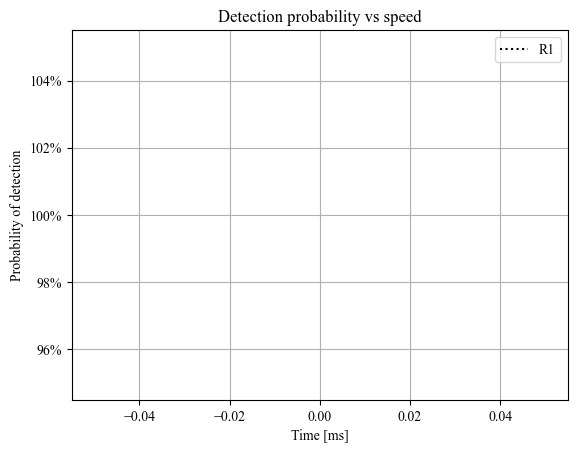

window idx
0.00%   100.00%
dtype: float64


In [32]:
from matplotlib.ticker import FuncFormatter

# df2, *_ = load_df(2)
# df4, *_ = load_df(4)
df1, *_ = load_df(1)
# # df2 = de.trip_percentage(df2)
# # df4 = de.trip_percentage(df4)
df1 = de.trip_percentage(df1)
# # plt.plot(df2, label="R2", color="black")
# # plt.plot(df4, label="R4", linestyle="-.", color="black")
plt.plot(df1, label="R1", linestyle=":", color="black")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.title("Detection probability vs speed")
plt.xlabel("Time [ms]")
plt.ylabel("Probability of detection")
plt.gca().set_yticklabels([f"{x:.0%}" for x in plt.gca().get_yticks()])
plt.legend()
plt.grid()
plt.show()

print(df1)

In [7]:
p = df[df["True label"] == 1].event_idx.value_counts().shape[0]
n = df[df["True label"] == 0].event_idx.value_counts().shape[0]
print(f"Fault Events (True): {p} \nNon Fault Events (False): {n}")

tp, fp, tn, fn = de.test_result(df)
metrics = de.conf_matrix_metrics(np.array([tp, fp, tn, fn, tp + fn]))
de.print_metrics(metrics)
de.plot_confusion_matrix(metrics)

Fault Events (True): 613 
Non Fault Events (False): 687
True Positives: 613 
False Positives: 0 
True Negatives: 687 
False Negatives: 0
Total Samples:................1300
True Positives:............... 613
False Positives:..............   0
True Negatives:............... 687
False Negatives:..............   0
Accuracy:..................... 100.0%
True Positive Rate:........... 100.0%
False Positive Rate:..........   0.0%
True Negative Rate:........... 100.0%
Positive Predictive Value:.... 100.0%


In [8]:
print(false_negative["Pred probability"].apply(np.floor).min())
print(false_negative["Pred probability"].min())
print(false_negative["Pred probability"].round(3).min())
print(false_negative["Pred probability"].max())
print(false_positive["Pred probability"].apply(np.floor).min())
print(false_positive["Pred probability"].max())
print(false_positive["Pred probability"].round(3).max())

min_range = (
    range(6) if (false_negative["Pred probability"].min() < 0.5) else range(5, 11)
)
print(min_range)

nan
nan
nan
nan
nan
nan
nan
range(5, 11)


In [9]:
# Data Exploration on False Positives and False Negatives

false_positive = df[df["Result"] == "FP"]
false_negative = df[df["Result"] == "FN"]
de.false_events_plots(false_positive, "False Positive")
de.false_events_plots(false_negative, "False Negatives")